## Key Takeaways

### For NNs using Images
- Convolutions are helpful
- SGD isn't as good as newer optimizers like Adam and NesterovAdam - https://towardsdatascience.com/types-of-optimization-algorithms-used-in-neural-networks-and-ways-to-optimize-gradient-95ae5d39529f
- normalization is helpful (both of the features and the output) and helps prevent divergence
- batch normalization works well after the activation https://github.com/ducha-aiki/caffenet-benchmark/blob/master/batchnorm.md
- need to go deeper as validation loss is brought in line with training loss


### Generally
- Never trust the data blindly


#### Link to models
https://drive.google.com/drive/folders/1IcfVLCy_btNzYmqzvKzyVPFQQkKrYVvZ?usp=sharing

## Setup

### Imports

In [1]:
%matplotlib inline
from pandas.io.parsers import read_csv
from sklearn.model_selection import train_test_split

import os
import pickle

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from keras.models import Sequential, load_model, Model
from keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, Dropout, BatchNormalization
from keras.layers import GlobalAveragePooling2D
from keras.optimizers import Nadam
from keras.callbacks import EarlyStopping, Callback, History
from keras.applications.inception_v3  import InceptionV3

from tensorflow.python.client import device_lib

from augmentdata.CustImageDataGenerator import CustImageDataGenerator,CustNumpyArrayIterator

print(device_lib.list_local_devices()) # confirm using GPU

c:\program files\python36\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 6106182770494605511
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 2760216576
locality {
  bus_id: 1
  links {
  }
}
incarnation: 17606271991635141360
physical_device_desc: "device: 0, name: GeForce GTX 780M, pci bus id: 0000:01:00.0, compute capability: 3.0"
]


### Constants

In [2]:
TRAIN_DATA = '../data/training.csv'                # train dataset downloaded from Kaggle
TEST_DATA = '../data/test.csv'                     # test dataset downloaded from Kaggle
IMAGE_ROWS = 96
IMAGE_COLS = 96
INPUT_SHAPE = (IMAGE_ROWS, IMAGE_COLS, 1)
RETRAIN = False                                    # bool to load and use existing saved models
VERBOSE_TRAIN = False                              # bool to show/hide progress while training a model
NUM_KEYPOINTS = 30                                 # maximum no. of facial keypoints for any image


## EDA on train dataset

We begin by examining the train dataset of images (training.csv file), which is organised as (x,y) coodinates of each of the 15 facial features for a total of 30 keypoints. The 31st column contains 96x96 image pixel array data coded as raw grayscale values from 0 to 255. There are a total of about 7000 images in the train dataset. 

**Summary**: 
*For the EDA, the first pass was done over the whole dataset. From this, roughly 320 images were identified that had missing keypoints or peculiarities, needing further evaluation. In this second pass, we decided to prune the input train dataset to the models, by picking out images that were misfits, and would likely end up confusing the model, rather than helping it. This analysis and some interesting images we came across are illustrated below.*


In [3]:
# Setting up the data for EDA

df_train = pd.read_csv(TRAIN_DATA)
Y = np.array(df_train[df_train.columns.difference(['Image'])])
X = df_train['Image']
labels = list(df_train.columns.difference(['Image']))

img_vec_len = IMAGE_ROWS*IMAGE_COLS                             # images pixel grid size

imgArray = np.zeros((X.shape[0], img_vec_len), dtype=int)       # temporary array to save each image as numpy array

idx=0
for i in X.keys(): 
    imgArray[idx] = np.fromstring(X[i], dtype=int, sep=' ')
    idx += 1
X = np.reshape( imgArray, (X.shape[0], IMAGE_ROWS, IMAGE_COLS, 1) )
print("Total images in train dataset: ", X.shape[0])

Total images in train dataset:  7049


In [4]:
# Function to subplot a group of images, and label the ones with missing keypoints distinctly

def plot_images(images, points, type='actual', subplotting=False, gridRows=0, gridCols=0, 
                imageIndices=1, subtitles=True, title=None, labelsList=[] ):
    
    plt.figure(figsize=(4*gridCols, 4*gridCols))    
    img_nums = images.shape[0]
    points_nums = points.shape[0]
    
    if ( ( img_nums != points_nums) | ( img_nums != imageIndices.shape[0] ) ):
        raise ValueError("Mismatch in number of images and keypoints' rows passed to plot_images().")
    
    
    for thisImg in range(0, gridRows*gridCols ):
        
        if subplotting:
            plt.subplot(gridRows, gridCols, thisImg + 1)
            noKeypNums  = np.isnan(points[thisImg]).sum()
            
            if subtitles:
                if( noKeypNums == 0 ):                                                            # no missing keypoints (group1)
                    plt.title("#: " + str(imageIndices[thisImg]) + 
                              ",  Points: " + str(NUM_KEYPOINTS - noKeypNums), color='k')         # title in black
                
                elif( ( noKeypNums > 0) & (noKeypNums < 22 ) ):                                   # (1,21) missing keypoints
                    plt.title("#: " + str(imageIndices[thisImg]) + 
                              ",  Points: " + str(NUM_KEYPOINTS - noKeypNums), color='m')         # title in magenta
                
                elif( ( noKeypNums == 22 ) ):                                                     # 22 missing keypoints (group2)
                    plt.title("#: " + str(imageIndices[thisImg]) + 
                              ",  Points: " + str(NUM_KEYPOINTS - noKeypNums), color='b')         # title in blue
                
                else:                                                                             # > 22 missing keypoints
                    plt.title("#: " + str(imageIndices[thisImg]) + 
                              ",  Points: " + str(NUM_KEYPOINTS - noKeypNums), color='r')         # title in red
        
        plt.imshow(np.reshape(images[thisImg,:],(96,96)), cmap = 'gray')

        x = 0
        for idx in range(0, points[thisImg].shape[0]):
            label = labelsList[idx]
            if label[-1]=='x':
                x = points[thisImg, idx]
            else:
                if label in ['left_eye_center_y',
                             'left_eye_inner_corner_y', 
                             'left_eye_outer_corner_y', 
                             'left_eyebrow_inner_end_y', 
                             'left_eyebrow_outer_end_y',
                             'mouth_left_corner_y'
                            ]:
                    if(type=='actual'):
                        plt.plot(x, points[thisImg, idx], 'c<')
                    else:
                        plt.plot(x, points[thisImg, idx], 'c*')
                        
                elif label in ['right_eye_center_y',
                             'right_eye_inner_corner_y', 
                             'right_eye_outer_corner_y', 
                             'right_eyebrow_inner_end_y', 
                             'right_eyebrow_outer_end_y',
                              'mouth_right_corner_y']:
                    if(type=='actual'):
                        plt.plot(x, points[thisImg, idx], 'r>')
                    else:
                        plt.plot(x, points[thisImg, idx], 'r*')
                
                else:
                    if(type=='actual'):
                        plt.plot(x, points[thisImg, idx], 'mo')
                    else:
                        plt.plot(x, points[thisImg, idx], 'm*')
                    
        plt.axis('off')
    
    if (title != None):
        plt.suptitle(title)
    plt.show()

In [5]:
# Function to plot an array of image indices

idx_max = df_train.shape[0]                      # all images
grid_cols = 4                                    # grid columns size for a subplot of images
grid_rows = 4                                    # grid rows size for images subplot
subImgNum = grid_cols * grid_rows

def plot_img_group( thisGroup, dataset='train', denorm=False, thisLabels=labels, thisSubTitle=True, thisTitle=None ):

    if(dataset == 'train'):
        thisX = X
        thisY = Y
    elif(dataset == 'group1'):
        thisX = X1
        thisY = Y1
    elif(dataset == 'group2'):
        thisX = X2
        thisY = Y2     
    
    thisSubsetX = np.zeros( (subImgNum, IMAGE_ROWS, IMAGE_COLS, 1), dtype=float)
    thisSubsetY = np.zeros( (subImgNum, thisY.shape[1]), dtype=float)
    img_indices = np.zeros( (subImgNum, 1), dtype=int)

    img_sub = 0                                  # local iterator for images in subplot
    flushed = False
    for img in thisGroup:
        
        if( ( (img_sub + 1 )  % subImgNum ) != 0 ):
            thisSubsetX[img_sub,:] = thisX[img-1,:]
            if denorm:
                thisSubsetY[img_sub,:] = 48*thisY[img-1,:] + 48
            else:
                thisSubsetY[img_sub,:] = thisY[img-1,:]
            img_indices[img_sub] = img
            img_sub += 1
            flushed = False
            
        else:
            thisSubsetX[img_sub,:] = thisX[img-1,:]
            if denorm:
                thisSubsetY[img_sub,:] = 48*thisY[img-1,:] + 48
            else:
                thisSubsetY[img_sub,:] = thisY[img-1,:]
            img_indices[img_sub] = img
            
            # plot when all images for the subplot are accumulated
            plot_images(images=thisSubsetX, points=thisSubsetY, subplotting=True, 
                        gridRows=grid_rows, gridCols=grid_cols, imageIndices=img_indices, 
                        subtitles=thisSubTitle, title=thisTitle, labelsList=thisLabels )
            
            # reset subplot indexing pointer and subplot image/keypoints buckets
            img_sub = 0
            flushed = True
            thisSubsetX = np.zeros( (subImgNum, IMAGE_ROWS, IMAGE_COLS, 1), dtype=int)
            thisSubsetY = np.zeros( (subImgNum, Y.shape[1]), dtype=float)
    
    if not flushed:                              # for images leftover from partial subplot grid

        thisGridRows = ( (img_sub - 1) // grid_rows ) + 1
        if( thisGridRows > 1 ):
            thisGridCols = grid_cols
        else:
            thisGridCols = img_sub

        plot_images(images=thisSubsetX, points=thisSubsetY, subplotting=True, 
                    gridRows=thisGridRows, gridCols=thisGridCols, imageIndices=img_indices, 
                    subtitles=thisSubTitle, title=thisTitle, labelsList=thisLabels )


The images in the train dataset seem to be broadly split into two groups. The first group starts from the beginning of the dataset and (index 1, or row 1 in .csv) and continues till index 2284. Beyond that, the images have a maximum of 8 keypoints.

Below is a sample of images around this boundary - images with 30 keypoints or less and those with 8 keypoints or less. Also, there are some images with missing keypoints, with their titles highlighted in magenta or red colors.

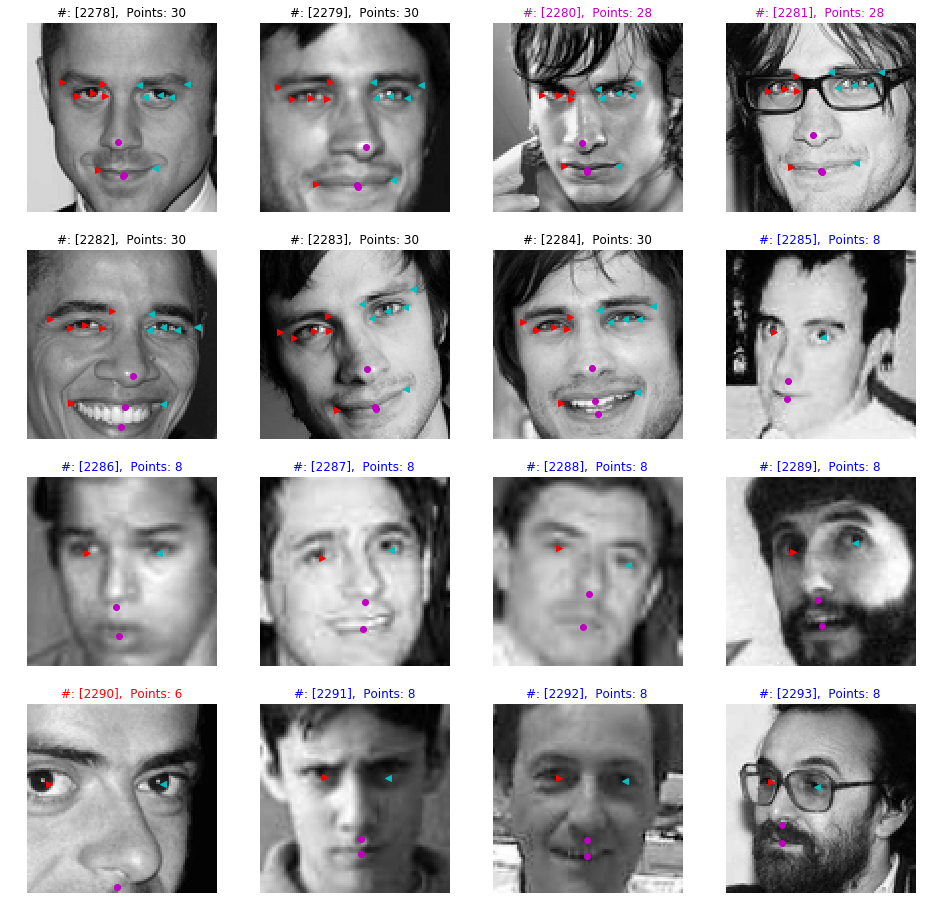

In [6]:
sample_group_split = 2278                        # sample few images around boundary of group1 and group2
group_1_2 = np.arange(sample_group_split, sample_group_split + 16)
plot_img_group( group_1_2 )

After examining each image in the dataset, the images were split into two groups: - group1 images typically have 30 keypoints, while group2 images have typically 8 keypoints or less. Also, approx. 320 total images were identified for further examination, some of which are discussed below: 

#### Group1:

##### Eyes closed: 
For identifying the center of eye keypoint, these images just have approximate labelling of that keypoint, without providing a high level of feature extraction for the model e.g. the absence contrast between the white sclera and the relatively darker eyelids or iris. But since the dataset has more than 300+ such images, these probably are common in the test dataset (an educated guess) and hence should not be ruled out from training dataset.



Sample images with eyes closed


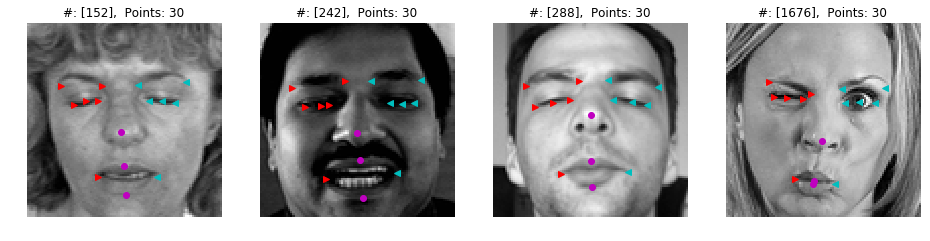

In [7]:
imgs_eyes_closed    = np.array([152, 242, 288, 1676])

print("\nSample images with eyes closed")
plot_img_group( imgs_eyes_closed )



#### Group2:

##### Highly blurred:
Group 2 has much higher share of images that are highly blurred out to provide any significant feature extractions. These may not be useful for training the model at all. 



Sample images that are highly blurred


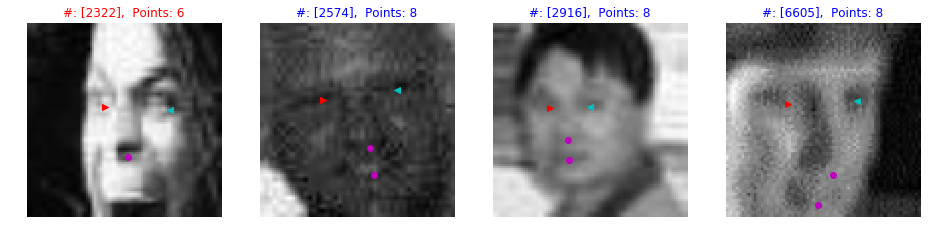

In [8]:
imgs_high_blur    = np.array([2322, 2574, 2916, 6605])

print("\nSample images that are highly blurred")
plot_img_group( imgs_high_blur )

#### Common to both groups:

##### Partially/fully covered keypoints:
These images have section around the eyes partially covered with hairs, hat etc. or other facial sections obstructed by various objects, props, sunglassed or face is partially placed in dark shadow. These again have approximations of the obscured keypoint. The question is whether this provides any real feature to extract for the model or not. Most of these were finally left in the dataset, as atleast the unobstructed keypoints will atleast serve as just fine. 

##### A second partial/full face:
Some images have more than one face either partially or fully appearing in the foreground/background. Although some of these are labelled correctly, this can probably mislead the model, especially in cases there more than face is having keypoints. Some of these in which the primary face was deemphasized, were dropped from the training dataset. 

##### Wrong/bad labels:
These images outright have wrong labelling and should be removed from the train dataset. 

##### Missing keypoints:
Most of such images e.g. with only 28 or 26 keypoints for group1, and, 6 or 4 keypoints for group2 are either out of frame, or have the face viewed sideways, or overshadowed and hence aren't able to capture/specify all keypoints, but nevertheless are quite valid for training.



Sample images with partial or fully covered/obscured keypoints


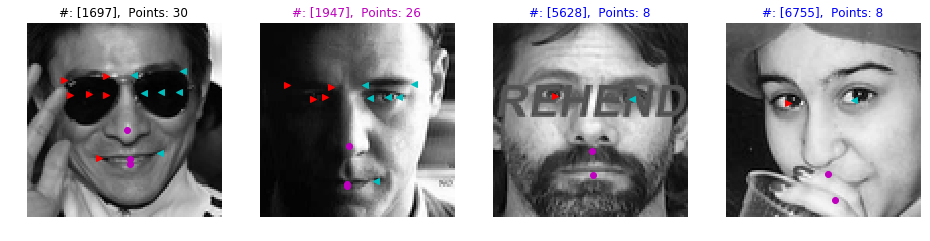


Sample images with a second partial/full face


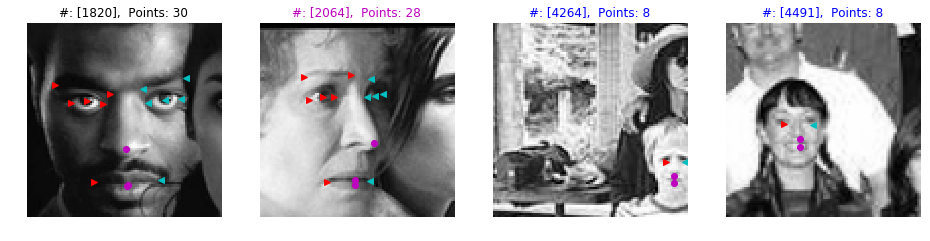


Sample images with bad/wrong labelling


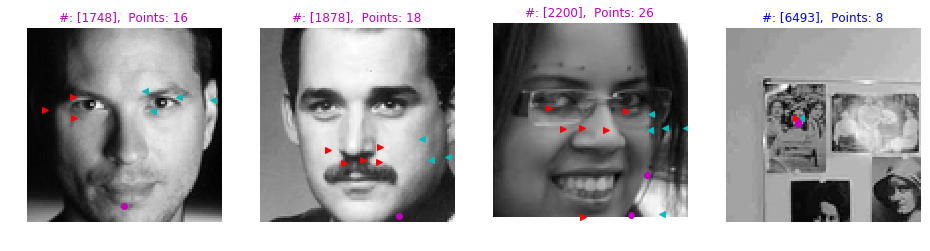


Sample images with missing keypoints


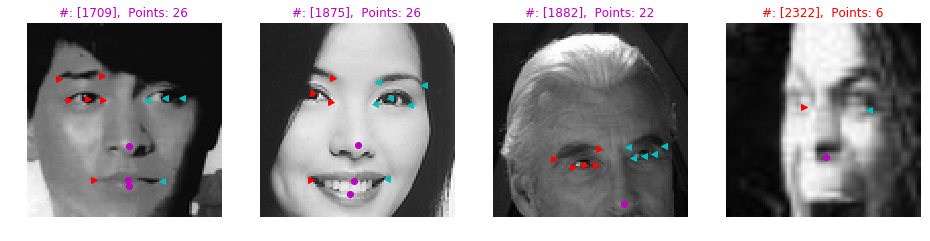

In [9]:
imgs_obstructed     = np.array([1697, 1947, 5628, 6755])
imgs_2nd_face       = np.array([1820, 2064, 4264, 4491])
imgs_bad_labels     = np.array([1748, 1878, 2200, 6493])
imgs_miss_keyps     = np.array([1709, 1875, 1882, 2322])

print("\nSample images with partial or fully covered/obscured keypoints")
plot_img_group( imgs_obstructed )

print("\nSample images with a second partial/full face")
plot_img_group( imgs_2nd_face )

print("\nSample images with bad/wrong labelling")
plot_img_group( imgs_bad_labels )

print("\nSample images with missing keypoints")
plot_img_group( imgs_miss_keyps )

Based on this analysis, we decided to build 2 separate models, one for group2 images with 8 keypoints or less, and another for group1, with more than 8 keypoints. 

There are also some subtle differences between the nose keypoints between the two groups e.g. group1 images have the tip of nose marked, while the group2 images have the underside of nose marked.

After the EDA, the final images to be removed from training dataset were selected, and then the data was split into group1 ( more than 8 keypoints) and group2 (upto 8 keypoints) dataset.

In [10]:
# Final indices of images to be dropped from the dataset

IDX_BAD_IMAGES = np.array( [1621, 1862, 1748, 1878, 1927, 2200, 2431, 2584, 2647, 
                            2671, 2765, 4198, 1627, 1628, 1637, 1957, 4477, 1820, 
                            2064, 2089, 2091, 2109, 2195, 4264, 4491, 6490, 6493, 
                            6494, 1655, 2096, 2454, 3206, 3287, 5628, 5653, 6754, 
                            6755, 2321, 2322, 2414, 2428, 2462, 2574, 2584, 2663, 
                            2691, 2694, 2830, 2910, 2916, 3126, 3176, 3291, 3299, 
                            3361, 4061, 4483, 4484, 4494, 4766, 4809, 4837, 4880, 
                            4905, 5068, 5362, 5566, 5868, 6535, 6538, 6588, 6605, 
                            6659, 6724, 6733, 6753, 6758, 6766, 6907 ] )
#plot_img_group( IDX_BAD_IMAGES )

### Preparing the training data for models

In [11]:
# Function to clean up the train dataset, normalize it, drop bad images & labels, 
# and finally split the dataset into 2, for group1 and group2 modelling.

def loaderV2(test=False, seed=None, keeplabels=None):
    
    if seed:
        np.random.seed(seed)
    fileloc = TEST_DATA if test else TRAIN_DATA
    
    df = read_csv(fileloc)
    
    df['Image'] = df['Image'].apply(lambda x: np.fromstring(x, sep=' '))
    
    if keeplabels:
        df = df[list(keeplabels) + ['Image']]
        
    X = np.vstack(df['Image'])
    
    if not test:                                                  # process train dataset
        Y = df[df.columns.difference(['Image'])].values
        Y = Y.astype(np.float32)
        
        # remove rows having bad images or labels
        X = np.delete( X, (IDX_BAD_IMAGES - 1), axis=0 )
        Y = np.delete( Y, (IDX_BAD_IMAGES - 1), axis=0 )
        
        # normalize - by pixel across the whole dataset subtract mean and divide by stdev
        X = X - np.tile(np.mean(X,axis=0),(X.shape[0],1))
        X = X / np.tile(np.std(X,axis=0),(X.shape[0],1))
        X = X.astype(np.float32)
    
        Y = (Y - 48) / 48                     # this helps, but tanh on output doesnt
        shuffle = np.random.permutation(np.arange(X.shape[0]))
        X, Y = X[shuffle], Y[shuffle]
    
        X = X.reshape(-1, 96, 96, 1)
        
        # split X and Y into dataset for model1 (more than 8 keypoints) and model2 (less than 8 keypoints)
        X_model1 = np.zeros( (X.shape[0], 96,96,1), dtype=np.float32)
        X_model2 = np.zeros( (X.shape[0], 96,96,1), dtype=np.float32)
        Y_model1 = np.zeros( Y.shape, dtype=float)
        Y_model2 = np.zeros( Y.shape, dtype=float)
        tempIdx1 = 0
        tempIdx2 = 0
        
        for thisIdx in range(0, Y.shape[0]):
            numKeyps  = NUM_KEYPOINTS - np.isnan(Y[thisIdx]).sum()
            
            if( ( numKeyps > 8 ) ):
                X_model1[tempIdx1] = X[thisIdx,:,:]
                Y_model1[tempIdx1] = Y[thisIdx,:]
                tempIdx1 = tempIdx1 + 1
            else:
                X_model2[tempIdx2] = X[thisIdx,:,:]
                Y_model2[tempIdx2] = Y[thisIdx,:]
                tempIdx2 = tempIdx2 + 1
    
        # remove empty rows
        drop_idx1 = []
        drop_idx2 = []
        
        for idx in range(0, X.shape[0]):
            if( (np.all(Y_model1[idx] == 0)) | (np.isnan(Y_model1[idx]).sum() != 0) ):
                drop_idx1.append(idx)
            if( (np.all(Y_model2[idx] == 0)) | (np.isnan(Y_model2[idx]).sum() != 22) ):
                drop_idx2.append(idx)
        
        X_model1 = np.delete( X_model1, np.array(drop_idx1), axis=0 )
        Y_model1 = np.delete( Y_model1, np.array(drop_idx1), axis=0 )
        X_model2 = np.delete( X_model2, np.array(drop_idx2), axis=0 )
        Y_model2 = np.delete( Y_model2, np.array(drop_idx2), axis=0 )            
        
        # remove empty columns, setup lists of labels
        labels = df.columns.difference(['Image'])
        labels1 = labels
        labels2 = []
        drop_idx3 = []
        for idx in range(0, Y.shape[1]):
            if( (np.all(Y_model2[:,idx] == 0)) | (np.isnan(Y_model2[:,idx]).sum() != 0) ):
                drop_idx3.append(idx)
            else:
                labels2.append(labels[idx])
        Y_model2 = np.delete( Y_model2, np.array(drop_idx3), axis=1 ) 
        
        # return the original dataset and the group splits
        return X_model1, Y_model1, labels1, X_model2, Y_model2, labels2, X, Y, labels
    
    else:                                             # for test dataset
        Y = None
        
        # normalize - by pixel across the whole dataset subtract mean and divide by stdev
        X = X - np.tile(np.mean(X,axis=0),(X.shape[0],1))
        X = X / np.tile(np.std(X,axis=0),(X.shape[0],1))
        X = X.reshape(-1, 96, 96, 1)
        labels = df.columns.difference(['Image'])
        
        return X, Y, labels
    

In [12]:
X1, Y1, labels1,   X2, Y2, labels2,   X, Y, labels = loaderV2(seed=42)

X1_train, X1_test, Y1_train, Y1_test = train_test_split(X1, Y1,
                                                        test_size=0.2,
                                                        random_state=42)

X2_train, X2_test, Y2_train, Y2_test = train_test_split(X2, Y2,
                                                        test_size=0.2,
                                                        random_state=42)

data1 = [X1_train, X1_test, Y1_train, Y1_test]
data2 = [X2_train, X2_test, Y2_train, Y2_test]


In [13]:
print("Group1 data Y1 shape: ", Y1.shape, ", X1 shape: ", X1.shape)
print("Group2 data Y2 shape: ", Y2.shape, ", X2 shape: ", X2.shape)


Group1 data Y1 shape:  (2137, 30) , X1 shape:  (2137, 96, 96, 1)
Group2 data Y2 shape:  (4697, 8) , X2 shape:  (4697, 96, 96, 1)


### Plot some sample images


 Normalized Train dataset:


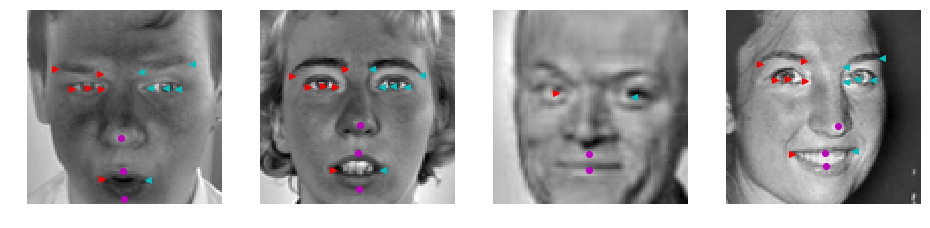


 Normalized Group1 dataset:


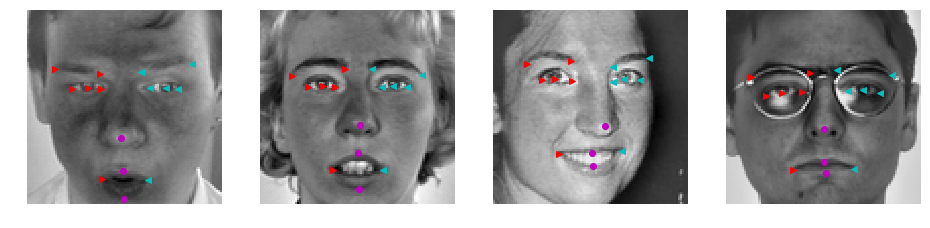


 Normalized Group2 dataset:


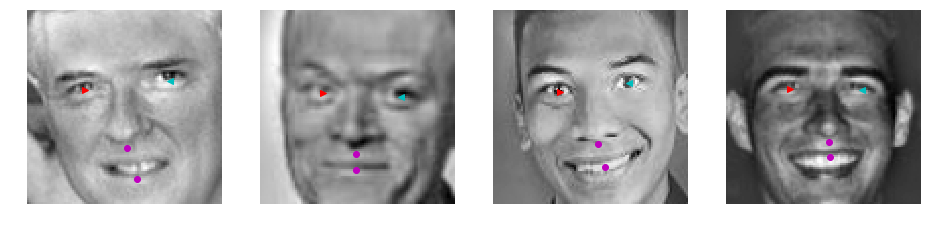

In [14]:
# Checking some images from both groups

print("\n Normalized Train dataset:")
temp_idx = 0                                         # reference starting index for images to be examined
sample_train = np.arange(temp_idx, temp_idx+4)
plot_img_group( sample_train, dataset='train', denorm=True, thisLabels=labels, thisSubTitle=False )

print("\n Normalized Group1 dataset:")
sample_group1 = np.arange(temp_idx, temp_idx+4)
plot_img_group( sample_group1, dataset='group1', denorm=True, thisLabels=labels1, thisSubTitle=False )

print("\n Normalized Group2 dataset:")
sample_group2 = np.arange(0,4)
plot_img_group( sample_group2, dataset='group2', denorm=True, thisLabels=labels2, thisSubTitle=False )


### Model Fitting Function

In [15]:
def fit_model(model, data, modelname,
              generator=None,retrain=RETRAIN,
              epochs=10000, patience=1000):
    if retrain or not os.path.exists('../saved-models/' + modelname + '.h5'):
        X_train = data[0]
        y_train = data[2]
        if len(data) == 4:
            valid_dat = (data[1], data[3])
        else:
            valid_dat = None

        model.compile(loss='mse', optimizer=Nadam())
        
        if valid_dat:
            earlystop = EarlyStopping(monitor='val_loss',
                                     patience=patience,
                                     verbose=1,
                                     mode="auto")
            callbacks = [earlystop]
        else:
            callbacks = None
        
        if generator:
            history = model.fit_generator(generator,
                        epochs=epochs,
                        steps_per_epoch=data[0].shape[0]//32,
                        callbacks=callbacks,
                        validation_data=valid_dat
             )
        else:
            history = model.fit(X_train, y_train,
                                epochs=epochs,
                                batch_size=32,
                                callbacks=callbacks,
                                validation_data=valid_dat,
                                verbose=VERBOSE_TRAIN
                     )
        model.save('../saved-models/'+ modelname + '.h5')
        with open('../saved-models/histories/'+modelname+'_hist',
                  'wb') as file_pi:
            pickle.dump(history.history, file_pi)
        history = history.history
    else:
        model = load_model('../saved-models/'+modelname+'.h5')
        history = pickle.load(open( "../saved-models/histories/" + modelname + '_hist',
                                   "rb" ))
        
    return history, model

### Helper function to plot the loss

In [16]:
def plot_loss(hists, names):
    colordict = {
        0 : 'b',
        1 : 'g',
        2 : 'r',
        3 : 'o',
        4 : 'p'
    }
    
    for i, hist in enumerate(hists):
        plt.plot([np.sqrt(x) * 48 for x in hist['loss']],
                 color=colordict[i],
                 label="train " + names[i])
        plt.plot([np.sqrt(x) * 48 for x in hist['val_loss']],
                 color=colordict[i],
                 linestyle=':',
                 label="valid " + names[i])
        plt.grid()
        plt.legend()
        plt.xlabel("epoch")
        plt.ylabel("RMSE")
        plt.yscale("log")
    plt.show()

## Models for group1 dataset (images with more than 8 keypoints)
### 1 Dense Hidden Layer with 100 units

In [17]:
g1_model1 = Sequential()
g1_model1.add(Flatten(input_shape=INPUT_SHAPE))
g1_model1.add(Dense(100, activation='relu'))
g1_model1.add(Dense(30))
print(g1_model1.summary())
g1_model1_hist, g1_model1 = fit_model(g1_model1, data1, 'g1_1dense100neuronlayer')

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_1 (Flatten)          (None, 9216)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 100)               921700    
_________________________________________________________________
dense_2 (Dense)              (None, 30)                3030      
Total params: 924,730
Trainable params: 924,730
Non-trainable params: 0
_________________________________________________________________
None


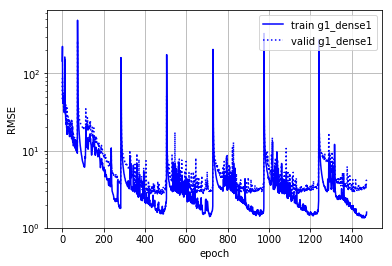

In [18]:
plot_loss([g1_model1_hist],['g1_dense1'])

In [19]:
g1_model1BN = Sequential()
g1_model1BN.add(Flatten(input_shape=INPUT_SHAPE))
g1_model1BN.add(Dense(100, activation='relu'))
g1_model1BN.add(BatchNormalization())
g1_model1BN.add(Dense(30))
print(g1_model1BN.summary())
g1_model1BN_hist, g1_model1BN = fit_model(g1_model1BN, data1,
                                    'g1_1dense100neuronlayer_wbatchnormalization')


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_2 (Flatten)          (None, 9216)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 100)               921700    
_________________________________________________________________
batch_normalization_1 (Batch (None, 100)               400       
_________________________________________________________________
dense_4 (Dense)              (None, 30)                3030      
Total params: 925,130
Trainable params: 924,930
Non-trainable params: 200
_________________________________________________________________
None


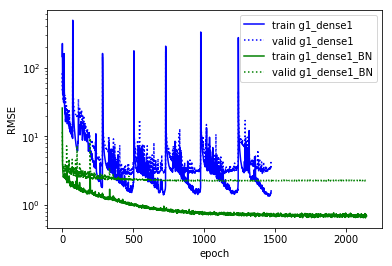

In [20]:
plot_loss([g1_model1_hist, g1_model1BN_hist],['g1_dense1','g1_dense1_BN'])

### Model with convolutions

In [ ]:
g1_model2 = Sequential()
g1_model2.add(Conv2D(32,
                 (3, 3),
                 activation='relu',
                input_shape=INPUT_SHAPE))
g1_model2.add(BatchNormalization())
g1_model2.add(MaxPooling2D(pool_size=(2, 2)))
g1_model2.add(Conv2D(filters=64,
                 kernel_size=(2, 2),
                 activation='relu'))
g1_model2.add(BatchNormalization())
g1_model2.add(MaxPooling2D(pool_size=(2, 2)))
g1_model2.add(Conv2D(filters=128,
                 kernel_size=(2, 2),
                 activation='relu'))
g1_model2.add(BatchNormalization())
g1_model2.add(MaxPooling2D(pool_size=(2, 2)))
g1_model2.add(Flatten())
g1_model2.add(Dense(500, activation = "relu"))
g1_model2.add(BatchNormalization())
g1_model2.add(Dense(100, activation = "relu"))
g1_model2.add(BatchNormalization())
g1_model2.add(Dense(30))
print(g1_model2.summary())

g1_model2_hist, g1_model2 = fit_model(g1_model2, data1,
                                    'g1_CNN')

In [ ]:
plot_loss([g1_model1BN_hist, g1_model2_hist],['g1_dense1_BN','g1_CNN'])

### Use the custom generator to enhance the training data

In [ ]:
datagen = CustImageDataGenerator(
    rotation_range=5. #degrees
     ,horizontal_flip=True
     ,width_shift_range=.05 # percent of image width
     ,height_shift_range=.05 # percent of image height
    ).flow(X1_train,Y1_train,whichlabels=list(labels1), batch_size=32)

In [ ]:
# basically a copy of model 2, but will train with augmented data
g1_model2_augmented = Sequential()
g1_model2_augmented.add(Conv2D(32,
                 (3, 3),
                 activation='relu',
                input_shape=INPUT_SHAPE))
g1_model2_augmented.add(BatchNormalization())
g1_model2_augmented.add(MaxPooling2D(pool_size=(2, 2)))
g1_model2_augmented.add(Conv2D(filters=64,
                 kernel_size=(2, 2),
                 activation='relu'))
g1_model2_augmented.add(BatchNormalization())
g1_model2_augmented.add(MaxPooling2D(pool_size=(2, 2)))
g1_model2_augmented.add(Conv2D(filters=128,
                 kernel_size=(2, 2),
                 activation='relu'))
g1_model2_augmented.add(BatchNormalization())
g1_model2_augmented.add(MaxPooling2D(pool_size=(2, 2)))
g1_model2_augmented.add(Flatten())
g1_model2_augmented.add(Dense(500, activation = "relu"))
g1_model2_augmented.add(BatchNormalization())
g1_model2_augmented.add(Dense(100, activation = "relu"))
g1_model2_augmented.add(BatchNormalization())
g1_model2_augmented.add(Dense(30))
print(g1_model2_augmented.summary())
g1_model2_augmented_hist, g1_model2_augmented = fit_model(g1_model2_augmented, data1,
                                                    'g1_CNN_augmented', datagen)


In [ ]:
plot_loss([g1_model2_hist, g1_model2_augmented_hist],['g1_CNN','g1_CNN_augmented'])

The augmented data improves the validation RMSE by adding some variance to the training data.

### Add Dropout to avoid over-fitting and up the last hidden level

In [ ]:
g1_model3 = Sequential()
g1_model3.add(Conv2D(32,
                 (3, 3),
                 activation='relu',
                input_shape=INPUT_SHAPE))
g1_model3.add(BatchNormalization())
g1_model3.add(MaxPooling2D(pool_size=(2, 2)))
g1_model3.add(Dropout(.1))
g1_model3.add(Conv2D(filters=64,
                 kernel_size=(2, 2),
                 activation='relu'))
g1_model3.add(BatchNormalization())
g1_model3.add(MaxPooling2D(pool_size=(2, 2)))
g1_model3.add(Dropout(.2))
g1_model3.add(Conv2D(filters=128,
                 kernel_size=(2, 2),
                 activation='relu'))
g1_model3.add(BatchNormalization())
g1_model3.add(MaxPooling2D(pool_size=(2, 2)))
g1_model3.add(Dropout(.3))
g1_model3.add(Flatten())
g1_model3.add(Dense(500, activation = "relu"))
g1_model3.add(Dropout(.5))
g1_model3.add(BatchNormalization())
g1_model3.add(Dense(500, activation = "relu"))
g1_model3.add(BatchNormalization())
g1_model3.add(Dense(30))
print(g1_model3.summary())
g1_model3_hist, g1_model3 = fit_model(g1_model3, data1,
                                'g1_CNN_aug_dropout',datagen,
                                patience=1000)

In [ ]:
plot_loss([g1_model2_augmented_hist, g1_model3_hist],['g1_CNN_augmented','g1_CNN_aug_dropout'])

There is a bad issue with the variance, which is likely caused by the combination of dropout and BN. http://arxiv.org/abs/1801.05134v1. Try to fix it by only using dropout after all BN layers.

In [ ]:
g1_model3_v2 = Sequential()
g1_model3_v2.add(Conv2D(32,
                 (3, 3),
                 activation='relu',
                input_shape=INPUT_SHAPE))
g1_model3_v2.add(BatchNormalization())
g1_model3_v2.add(MaxPooling2D(pool_size=(2, 2)))
g1_model3_v2.add(Conv2D(filters=64,
                 kernel_size=(2, 2),
                 activation='relu'))
g1_model3_v2.add(BatchNormalization())
g1_model3_v2.add(MaxPooling2D(pool_size=(2, 2)))
g1_model3_v2.add(Conv2D(filters=128,
                 kernel_size=(2, 2),
                 activation='relu'))
g1_model3_v2.add(BatchNormalization())
g1_model3_v2.add(MaxPooling2D(pool_size=(2, 2)))
g1_model3_v2.add(Flatten())
g1_model3_v2.add(Dense(500, activation = "relu"))
g1_model3_v2.add(BatchNormalization())
g1_model3_v2.add(Dense(500, activation = "relu"))
g1_model3_v2.add(BatchNormalization())
g1_model3_v2.add(Dropout(.3))
g1_model3_v2.add(Dense(30))
print(g1_model3_v2.summary())
g1_model3_v2_hist, g1_model3_v2 = fit_model(g1_model3_v2, data1,
                                'g1_CNN_aug_dropout2',datagen,
                                patience=1000)


In [ ]:
plot_loss([g1_model2_augmented_hist, g1_model3_hist, g1_model3_v2_hist],
          ['g1_CNN_augmented','g1_CNN_aug_dropout', 'g1_CNN_aug_dropout2'])

The jump issue is fixed, but the model is not much better than before dropout.

** Usha to add her pieces here. I imagine her markdown description should first start by noting we need more layers because we are no longer overfitting so we want to add more variance to reduce the bias. 

Added 2 layers to best g1 model

In [ ]:
g1_model3_new = Sequential()
g1_model3_new.add(Conv2D(32,
                 (6, 6),
                 activation='relu',
                input_shape=INPUT_SHAPE))
g1_model3_new.add(BatchNormalization())
g1_model3_new.add(MaxPooling2D(pool_size=(2, 2)))
g1_model3_new.add(Conv2D(filters=64,
                 kernel_size=(5, 5),
                 activation='relu'))
g1_model3_new.add(BatchNormalization())
g1_model3_new.add(MaxPooling2D(pool_size=(2, 2)))

g1_model3_new.add(Conv2D(filters=256,
                 kernel_size=(4, 4),
                 activation='relu'))
g1_model3_new.add(BatchNormalization())
g1_model3_new.add(MaxPooling2D(pool_size=(2, 2)))
g1_model3_new.add(Conv2D(filters=64,
                 kernel_size=(3,3),
                 activation='relu'))
g1_model3_new.add(BatchNormalization())
g1_model3_new.add(MaxPooling2D(pool_size=(2, 2)))
g1_model3_new.add(Conv2D(filters=128,
                 kernel_size=(2, 2),
                 activation='relu'))
g1_model3_new.add(BatchNormalization())
g1_model3_new.add(MaxPooling2D(pool_size=(2, 2)))

g1_model3_new.add(Flatten())
g1_model3_new.add(Dense(500, activation = "relu"))
g1_model3_new.add(BatchNormalization())
g1_model3_new.add(Dense(500, activation = "relu"))
g1_model3_new.add(BatchNormalization())
g1_model3_new.add(Dropout(.3))
g1_model3_new.add(Dense(30))
print(g1_model3_new.summary())
g1_model3_new_hist, g1_model3_new = fit_model(g1_model3_new, data1,
                                'g1_CNN_aug_addedLayers',datagen,
                                patience=1000)

In [ ]:
plot_loss([g1_model2_augmented_hist, g1_model3_v2_hist, g1_model3_new_hist],
          ['g1_CNN_augmented','g1_CNN_aug_dropout2', 'g1_CNN_aug_addedLayers'])

### Using a model from the zoo
We try to train the InceptionV3 model to see if it does a better job. This model was chosen because it has good evaluation results, but has fewer parameters than some of the other competition-winning models.

#### Setup
In order to use InceptionV3, we need a 3 channel input. To fit this, we can just repeat the grayscale value for each of the 3 channels. We also have to change the data generator to create 3 channel images.

In [ ]:
# force grayscale into 3 channels
X1_train_3chan = np.tile(X1_train,(1,1,1,3))
X1_test_3chan = np.tile(X1_test,(1,1,1,3))
data1_inceptionV3=[X1_train_3chan, X1_test_3chan, Y1_train, Y1_test]

# new 3 channel data generator
datagen_inceptionV3 = CustImageDataGenerator(
    rotation_range=5. #degrees
     ,horizontal_flip=True
     ,width_shift_range=.05 # percent of image width
     ,height_shift_range=.05 # percent of image height
    ).flow(X1_train_3chan,Y1_train,whichlabels=list(labels1), batch_size=32)


#### Train the model
We train the model in 3 steps.
1. Create the base model and add a global average pooling layer, a dense layer, and an output layer. Then train the 3 added layers.
1. Train layers further up from the end (layer 250 through to the output layer).
1. Train all the layers.

In [ ]:
# create the base pre-trained model
base_model = InceptionV3(weights='imagenet', include_top=False)

# add a global spatial average pooling layer
x = base_model.output
x = GlobalAveragePooling2D()(x)
# let's add a fully-connected layer
x = Dense(1024, activation='relu')(x)
# add the keypoints detection layer
predictions = Dense(30)(x)

# this is the model we will train
model_inceptionV3 = Model(inputs=base_model.input, outputs=predictions)

# first: train only the top layers (which were randomly initialized)
# i.e. freeze all convolutional InceptionV3 layers
for layer in base_model.layers:
    layer.trainable = False

print(model_inceptionV3.summary())
model_inceptionV3_hist, model_inceptionV3 = fit_model(model_inceptionV3, data1_inceptionV3,
                                                      'g1_zoo', datagen_inceptionV3,
                                                      patience=1000)

In [ ]:
# at this point, the top layers are well trained and we can start fine-tuning
# convolutional layers from inception V3. We will freeze the bottom N layers
# and train the remaining top layers.

# we chose to train the top 2 inception blocks, i.e. we will freeze
# the first 249 layers and unfreeze the rest:
for layer in model_inceptionV3.layers[:249]:
    layer.trainable = False
for layer in model_inceptionV3.layers[249:]:
    layer.trainable = True

# we train our model again (this time fine-tuning the top 2 inception blocks
# alongside the top Dense layers
model_inceptionV3_hist2, model_inceptionV3 = fit_model(model_inceptionV3, data1_inceptionV3,
                                'g1_zoo2',datagen_inceptionV3,
                                patience=1000)


In [ ]:
# train all layers!
for layer in model_inceptionV3.layers:
    layer.trainable = True

# we train our model again (this time fine-tuning the top 2 inception blocks
# alongside the top Dense layers
model_inceptionV3_hist3, model_inceptionV3 = fit_model(model_inceptionV3, data1_inceptionV3,
                                'g1_zoo3',datagen_inceptionV3,
                                patience=1000)

In [ ]:
# compare loss
model_inceptionV3_hist_all = {}
model_inceptionV3_hist_all['loss'] = (model_inceptionV3_hist['loss'] +
                                      model_inceptionV3_hist2['loss'] +
                                      model_inceptionV3_hist3['loss']
                                      )
model_inceptionV3_hist_all['val_loss'] = (model_inceptionV3_hist['val_loss'] +
                                          model_inceptionV3_hist2['val_loss'] +
                                          model_inceptionV3_hist3['val_loss']
                                          )

plot_loss([g1_model2_augmented_hist, model_inceptionV3_hist_all],
           ['g1_CNN_augmented','g1_inceptionV3'])

It appears InceptionV3 loses out to our first data-augmented model. This is likely because we just don't have enough training examples to get enough variance into the Inception model that its generalization functionality works. It does appear the validation and training loss go hand in hand for the InceptionV3 model.

## Models for group2 dataset (images with 8 or less keypoints)

### 1 Dense Hidden Layer with 100 units

In [ ]:
g2_model1 = Sequential()
g2_model1.add(Flatten(input_shape=INPUT_SHAPE))
g2_model1.add(Dense(100, activation='relu'))
g2_model1.add(Dense(8))
print(g2_model1.summary())
g2_model1_hist, g2_model1 = fit_model(g2_model1, data2, 'g2_1dense100neuronlayer')

In [ ]:
plot_loss([g2_model1_hist],['g2_dense1'])

### Using batch normalization

In [ ]:
g2_model1BN = Sequential()
g2_model1BN.add(Flatten(input_shape=INPUT_SHAPE))
g2_model1BN.add(Dense(100, activation='relu'))
g2_model1BN.add(BatchNormalization())
g2_model1BN.add(Dense(8))
print(g2_model1BN.summary())
g2_model1BN_hist, g2_model1BN = fit_model(g2_model1BN, data2,
                                    'g2_1dense100neuronlayer_wbatchnormalization')

In [ ]:
plot_loss([g2_model1_hist, g2_model1BN_hist],['g2_dense1','g2_dense1_BN'])

### Convolutional model 1

In [ ]:
g2_model2 = Sequential()
g2_model2.add(Conv2D(32,
                 (3, 3),
                 activation='relu',
                input_shape=INPUT_SHAPE))
g2_model2.add(BatchNormalization())
g2_model2.add(MaxPooling2D(pool_size=(2, 2)))

g2_model2.add(Conv2D(filters=64,
                 kernel_size=(2, 2),
                 activation='relu'))
g2_model2.add(BatchNormalization())
g2_model2.add(MaxPooling2D(pool_size=(2, 2)))

g2_model2.add(Conv2D(filters=128,
                 kernel_size=(2, 2),
                 activation='relu'))
g2_model2.add(BatchNormalization())
g2_model2.add(MaxPooling2D(pool_size=(2, 2)))

g2_model2.add(Flatten())
g2_model2.add(Dense(500, activation = "relu"))
g2_model2.add(BatchNormalization())

g2_model2.add(Dense(100, activation = "relu"))
g2_model2.add(BatchNormalization())

g2_model2.add(Dense(8))
print(g2_model2.summary())

g2_model2_hist, g2_model2 = fit_model(g2_model2, data2,
                                    'g2_CNNv1')

In [ ]:
plot_loss([g2_model1BN_hist, g2_model2_hist],['g2_dense1_BN', 'g2_CNNv1'])

### Convolutional model 2 with more layers and tweaked kernel sizes

In [ ]:
g2_model3 = Sequential()

g2_model3.add(Conv2D(filters=64,
                 kernel_size=(6, 6),
                 strides=1,
                 activation='elu',
                 input_shape=INPUT_SHAPE))
g2_model3.add(BatchNormalization())
#g2_model3.add(MaxPooling2D(pool_size=(2, 2)))
g2_model3.add(Dropout(.1))

g2_model3.add(Conv2D(filters=128,
                 kernel_size=(5, 5),
                 strides=1,
                 activation='elu'))
g2_model3.add(BatchNormalization())
g2_model3.add(MaxPooling2D(pool_size=(2, 2)))
g2_model3.add(Dropout(.2))

g2_model3.add(Conv2D(filters=256,
                 kernel_size=(4, 4),
                 activation='elu'))
g2_model3.add(BatchNormalization())
g2_model3.add(MaxPooling2D(pool_size=(2, 2)))
g2_model3.add(Dropout(.2))

g2_model3.add(Conv2D(filters=512,
                 kernel_size=(3, 3),
                 activation='elu'))
g2_model3.add(BatchNormalization())
g2_model3.add(MaxPooling2D(pool_size=(2, 2)))
g2_model3.add(Dropout(.3))

g2_model3.add(Conv2D(filters=512,
                 kernel_size=(2, 2),
                 activation='elu'))
g2_model3.add(BatchNormalization())
g2_model3.add(MaxPooling2D(pool_size=(2, 2)))
g2_model3.add(Dropout(.4))

g2_model3.add(Flatten())
g2_model3.add(Dense(500, activation = "elu"))
g2_model3.add(BatchNormalization())
g2_model3.add(Dropout(.4))

#g2_model3.add(Dense(500, activation = "elu"))
#g2_model3.add(BatchNormalization())
#g2_model3.add(Dropout(.4))

g2_model3.add(Dense(100, activation = "elu"))
g2_model3.add(BatchNormalization())

g2_model3.add(Dense(8))

print(g2_model3.summary())

g2_model3_hist, g2_model3 = fit_model(g2_model3, data2,
                                    'g2_CNNv2')

In [ ]:
plot_loss([g2_model1BN_hist, g2_model2_hist, g2_model3_hist],['g2_dense1_BN', 'g2_CNNv1', 'g2_CNNv2'])

### Supplementing the model 3 with augmented data

In [ ]:
g2_datagen = CustImageDataGenerator(
    rotation_range=5. #degrees
     ,horizontal_flip=True
     ,width_shift_range=.05 # percent of image width
     ,height_shift_range=.05 # percent of image height
    ).flow(X2_train,Y2_train,whichlabels=list(labels2), batch_size=32)

In [ ]:
g2_model4 = Sequential()

g2_model4.add(Conv2D(filters=64,
                 kernel_size=(6, 6),
                 strides=1,
                 activation='elu',
                 input_shape=INPUT_SHAPE))
g2_model4.add(BatchNormalization())
#g2_model4.add(MaxPooling2D(pool_size=(2, 2)))
g2_model4.add(Dropout(.1))

g2_model4.add(Conv2D(filters=128,
                 kernel_size=(5, 5),
                 strides=1,
                 activation='elu'))
g2_model4.add(BatchNormalization())
g2_model4.add(MaxPooling2D(pool_size=(2, 2)))
g2_model4.add(Dropout(.2))

g2_model4.add(Conv2D(filters=256,
                 kernel_size=(4, 4),
                 activation='elu'))
g2_model4.add(BatchNormalization())
g2_model4.add(MaxPooling2D(pool_size=(2, 2)))
g2_model4.add(Dropout(.2))

g2_model4.add(Conv2D(filters=512,
                 kernel_size=(3, 3),
                 activation='elu'))
g2_model4.add(BatchNormalization())
g2_model4.add(MaxPooling2D(pool_size=(2, 2)))
g2_model4.add(Dropout(.3))

g2_model4.add(Conv2D(filters=512,
                 kernel_size=(2, 2),
                 activation='elu'))
g2_model4.add(BatchNormalization())
g2_model4.add(MaxPooling2D(pool_size=(2, 2)))
g2_model4.add(Dropout(.4))

g2_model4.add(Flatten())
g2_model4.add(Dense(500, activation = "elu"))
g2_model4.add(BatchNormalization())
g2_model4.add(Dropout(.4))

#g2_model4.add(Dense(500, activation = "elu"))
#g2_model4.add(BatchNormalization())
#g2_model4.add(Dropout(.4))

g2_model4.add(Dense(100, activation = "elu"))
g2_model4.add(BatchNormalization())

g2_model4.add(Dense(8))

print(g2_model4.summary())

g2_model4_hist, g2_model4 = fit_model(g2_model4, data2,
                                'g2_CNNv2_aug', g2_datagen,
                                patience=1000)

In [ ]:
plot_loss([g2_model2_hist, g2_model3_hist, g2_model4_hist],['g2_CNNv1', 'g2_CNNv2', 'g2_CNNv2_aug'])

## Create Predictions
### Load the Testing Time Images

In [ ]:
out_images, _ , _ = loaderV2(test=True, seed=None, keeplabels=None)
print(out_images.shape)

### Create the Predictions

In [ ]:
g1_final_model = g1_model2
g2_final_model = g2_model4

g1_prediction = g1_final_model.predict(out_images)
g2_prediction = g2_final_model.predict(out_images)

In [ ]:
print(g1_prediction.shape)
print(g2_prediction.shape)

### Plot some example predictions

In [ ]:
# sample random image predictions
testImage_Idx = [0,61,100,302,583,733,902,1221,1448,1743]
for idx in testImage_Idx:
    plot_image(out_images[idx], 48*g1_prediction[idx]+48, labels1, title="group1 model")
    plot_image(out_images[idx], 48*g2_prediction[idx]+48, labels2, title="group2 model")

# images that have labels outside the image
for i in np.where(np.max(np.abs(g1_prediction),axis=1)>1)[0]:
    plot_image(out_images[i],
        48*g1_prediction[i]+48, labels,title='test image # ' + str(i))


### Put the predictions into the submission format

In [ ]:
IdLookupTable = read_csv('../data/IdLookupTable.csv')
IdLookupTable.head()

In [ ]:
# aggregate the number of keypoints needed for each distinct Image in test dataset

rowIDs = np.array(IdLookupTable['RowId'])
imgs_numKeyps = np.zeros(max(IdLookupTable['ImageId']), dtype=int)      # keypoints to be predicted for each imageID
thisImgKeyps = 0

for rowIdx in range(0, rowIDs.shape[0]):
    thisImgID = IdLookupTable.loc[rowIdx,'ImageId']
    imgs_numKeyps[thisImgID - 1] += 1

print("Total test images: {}".format(imgs_numKeyps.shape) )


In [ ]:
label_locs1 = {}
label_locs2 = {}

for i, label in enumerate(labels1):
    label_locs1[label]=i

for i, label in enumerate(labels2):
    label_locs2[label]=i
    
IdLookupTable['test'] = IdLookupTable['FeatureName'].replace(label_locs1)

thisRowId = 0
modelUsed = np.zeros(IdLookupTable['RowId'].shape[0], dtype=int)

for imgIdx in range(0, imgs_numKeyps.shape[0]):
    
    if( imgs_numKeyps[imgIdx] > 8):
        for keypIdx in range(0, imgs_numKeyps[imgIdx]):
            map_label_idx = label_locs1[IdLookupTable.loc[thisRowId, 'FeatureName']]
            IdLookupTable.loc[thisRowId, 'Location'] =  (48*g1_prediction[imgIdx, map_label_idx]) + 48
            modelUsed[thisRowId] = 1
            thisRowId += 1
    else:
        for keypIdx in range(0, imgs_numKeyps[imgIdx]):
            map_label_idx = label_locs2[IdLookupTable.loc[thisRowId, 'FeatureName']]
            IdLookupTable.loc[thisRowId, 'Location'] =  (48*g2_prediction[imgIdx, map_label_idx]) + 48
            modelUsed[thisRowId] = 2
            thisRowId += 1

IdLookupTable['Location'] = (IdLookupTable['Location'].
                             where(IdLookupTable['Location']<=96, 96).
                             where(IdLookupTable['Location']>=0, 0)
                            )
IdLookupTable.head()

In [ ]:
Submission = IdLookupTable[['RowId','Location']]
Submission.head()

In [ ]:
Submission.to_csv(path_or_buf='./Submissions/Final_FacialKeypoints.csv',
                  index=False)

In [ ]:
Submission.describe()

In [ ]:
# Dump additional prediction info 
df_predic = IdLookupTable
df_predic['ModelUsed'] = modelUsed
df_predic.to_csv(path_or_buf='./Submissions/Prediction_debugInfo.csv',
                  index=False)